In [1]:
import sys
from pathlib import Path

current_path = %pwd
current_path = Path(current_path)
sys.path.insert(0, str(current_path.parent))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cuda_gpu_config
from run_model_v4 import load_config
from models.model_v4 import Model_v4
from models.utils import load_weights, latest_epoch
from data import preprocessing

%matplotlib inline

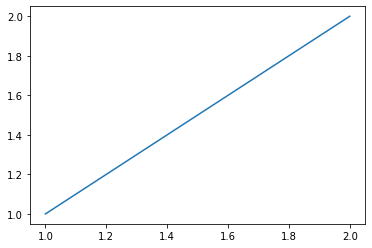

In [3]:
plt.plot([1,2], [1,2])

In [4]:
cuda_gpu_config.setup_gpu('3')

checkpoint_name = 'baseline_fc_8x16_elu_t1'

model_path = Path('../saved_models/cluster') / checkpoint_name
config = load_config(str(model_path / 'config.yaml'))
# config = load_config(str(model_path / '../baseline_fc_8x16_test/config.yaml'))
epoch = latest_epoch(model_path)

prediction_npz_file = model_path / f'prediction_{epoch:05d}.npz'

if prediction_npz_file.exists():
    f = np.load(prediction_npz_file)
    Y_train_fake = f['Y_train_fake']
    Y_train      = f['Y_train'     ]
    X_train      = f['X_train'     ]
    Y_test_fake  = f['Y_test_fake' ]
    Y_test       = f['Y_test'      ]
    X_test       = f['X_test'      ]
else:
    model = Model_v4(config)
    load_weights(model, model_path, epoch=epoch)

    preprocessing._VERSION = model.data_version
    data, features = preprocessing.read_csv_2d(pad_range=model.pad_range, time_range=model.time_range)
    features = features.astype('float32')

    data_scaled = model.scaler.scale(data).astype('float32')

    Y_train, Y_test, X_train, X_test = train_test_split(data_scaled, features, test_size=0.25, random_state=42)
    Y_train_fake = model.make_fake(X_train).numpy()
    Y_test_fake = model.make_fake(X_test).numpy()
    
    Y_train_fake[Y_train_fake < np.log10(2)] = 0
    Y_test_fake[Y_test_fake < np.log10(2)] = 0

    np.savez(
        prediction_npz_file,
        Y_train_fake = Y_train_fake,
        Y_train      = Y_train     ,
        X_train      = X_train     ,
        Y_test_fake  = Y_test_fake ,
        Y_test       = Y_test      ,
        X_test       = X_test      ,
    )

In [5]:
for i in [Y_train, Y_test, X_train, X_test, Y_train_fake, Y_test_fake]:
    print(i.shape, i.ravel()[50:55])

(15000, 8, 16) [0.        0.7473341 1.8435442 2.626956  2.9893162]
(5000, 8, 16) [0.         0.         0.57518786 1.8517474  2.771808  ]
(15000, 4) [105.694  41.372   0.597 -16.378 111.295]
(5000, 4) [199.847  44.66   -0.518 -24.15  146.426]
(15000, 8, 16) [0.         0.97502446 1.7760193  2.4324412  2.863718  ]
(5000, 8, 16) [0.        0.        0.3912279 1.540107  2.4478   ]


In [6]:
def prepare_classification(X, Y, Y_fake):
    features = (np.concatenate([X, X], axis=0),
                np.concatenate([Y, Y_fake], axis=0))
    targets = np.concatenate([
        np.ones(len(X), dtype=int),
        np.zeros(len(X), dtype=int)
    ])

    shuffle_ids = np.random.choice(len(targets), len(targets), replace=False)
    return (tuple(f[shuffle_ids] for f in features), targets[shuffle_ids])

ds_train = tf.data.Dataset.from_tensor_slices(
    prepare_classification(X_train, Y_train, Y_train_fake)
)
ds_test = tf.data.Dataset.from_tensor_slices(
    prepare_classification(X_test, Y_test, Y_test_fake)
)

In [7]:
from models.model_v4 import preprocess_features

dropout = 0.02

input_params = tf.keras.Input(shape=(4,))
input_img = tf.keras.Input(shape=(8, 16))

params = preprocess_features.python_function(input_params)

xx = tf.keras.layers.Reshape((8, 16, 1))(input_img)

def conv_block(xx, filters, kernel_size, padding, dropout):
    xx = tf.keras.layers.Conv2D(filters=filters,
                                kernel_size=kernel_size,
                                padding=padding)(xx)
    xx = tf.keras.layers.BatchNormalization()(xx)
    xx = tf.keras.layers.ELU()(xx)
    xx = tf.keras.layers.Dropout(rate=dropout)(xx)
    return xx

def fc_block(xx, units, dropout):
    xx = tf.keras.layers.Dense(units=units)(xx)
    xx = tf.keras.layers.BatchNormalization()(xx)
    xx = tf.keras.layers.ELU()(xx)
    xx = tf.keras.layers.Dropout(rate=dropout)(xx)
    return xx

xx = conv_block(xx, filters=8, kernel_size=(2, 3), padding='valid', dropout=dropout) # 7x14
xx = conv_block(xx, filters=16, kernel_size=(2, 3), padding='valid', dropout=dropout) # 6x12
xx = conv_block(xx, filters=32, kernel_size=1, padding='valid', dropout=dropout)
xx = tf.keras.layers.MaxPool2D()(xx) # 3x6

xx = conv_block(xx, filters=64, kernel_size=(2, 3), padding='valid', dropout=dropout) # 2x4
xx = conv_block(xx, filters=128, kernel_size=(2, 3), padding='valid', dropout=dropout) # 1x2
xx = tf.keras.layers.Reshape((256,))(xx)
xx = tf.keras.layers.Concatenate()([xx, input_params])

xx = fc_block(xx, units=128, dropout=dropout)
xx = xx + fc_block(xx, units=128, dropout=dropout)
xx = xx + fc_block(xx, units=128, dropout=dropout)
xx = xx + fc_block(xx, units=128, dropout=dropout)
xx = xx + fc_block(xx, units=128, dropout=dropout)
xx = xx + fc_block(xx, units=128, dropout=dropout)
logits = tf.keras.layers.Dense(units=1)(xx)

model = tf.keras.Model(inputs=[input_params, input_img],
                       outputs=logits, name='classifier')

In [8]:
model.compile(optimizer=tf.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             )#metrics=[tf.keras.metrics.AUC()])

In [9]:
model.fit(ds_train.batch(32), epochs=10, validation_data=ds_test.batch(512))

Train for 938 steps, validate for 20 steps
Epoch 1/10
938/938 [==============================] - 16s 17ms/step - loss: 0.2620 - val_loss: 0.0805
Epoch 2/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0610 - val_loss: 0.0360
Epoch 3/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0418 - val_loss: 0.0872
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0314 - val_loss: 0.0421
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0268 - val_loss: 0.0123
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0221 - val_loss: 0.0530
Epoch 7/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0212 - val_loss: 0.0363
Epoch 8/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0192 - val_loss: 0.0292
Epoch 9/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0177 - val_loss: 0.0386
Epoch 10/10
938/938 [==================

In [10]:
features_test, targets_test = prepare_classification(X_test, Y_test, Y_test_fake)

preds_test = model.predict(features_test)

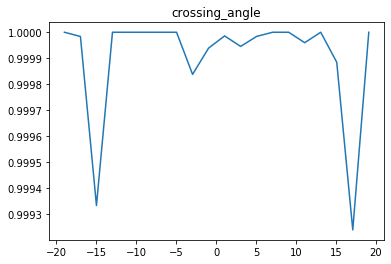

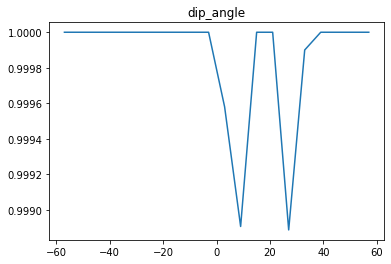

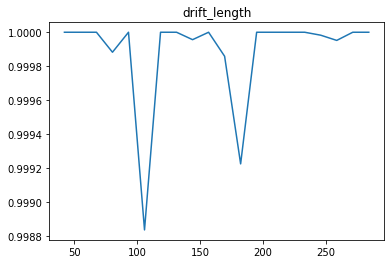

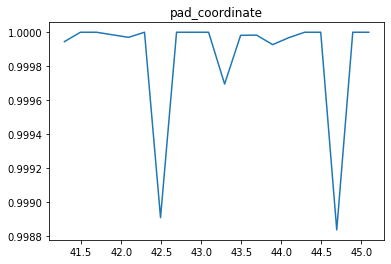

In [11]:
for f, label in zip(features_test[0].T,
                    ['crossing_angle', 'dip_angle', 'drift_length', 'pad_coordinate']):
    plt.figure()
    bins = np.linspace(f.min(), f.max() + 1e-5, 21)
    scores = []
    for left, right in zip(bins[:-1], bins[1:]):
        selection = (f >= left) & (f < right)
        scores.append(
            roc_auc_score(targets_test[selection], preds_test[selection])
        )
    scores = np.array(scores)
    plt.plot(0.5 * (bins[:-1] + bins[1:]), scores)
    plt.title(label)

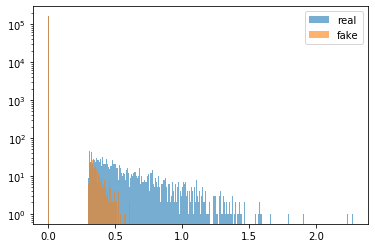

In [21]:
_, bins, _ = plt.hist(Y_test[:,-2:,:].ravel(), bins=300, alpha=0.6, label='real')
plt.hist(Y_test_fake[:,-2:,:].ravel(), bins=bins, alpha=0.6, label='fake')
plt.yscale('log')
plt.legend();

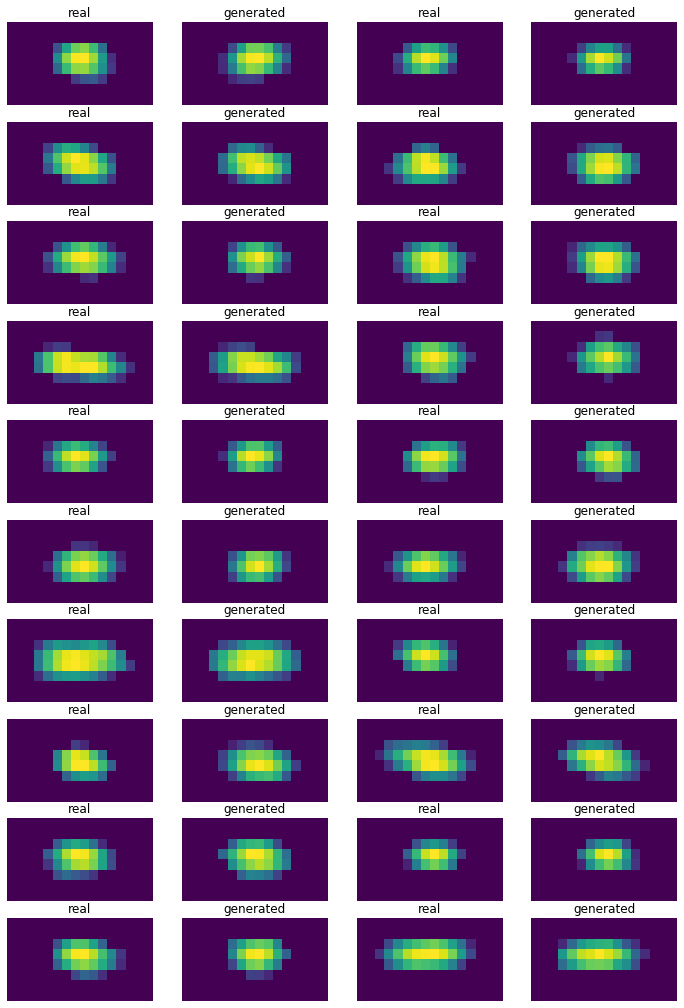

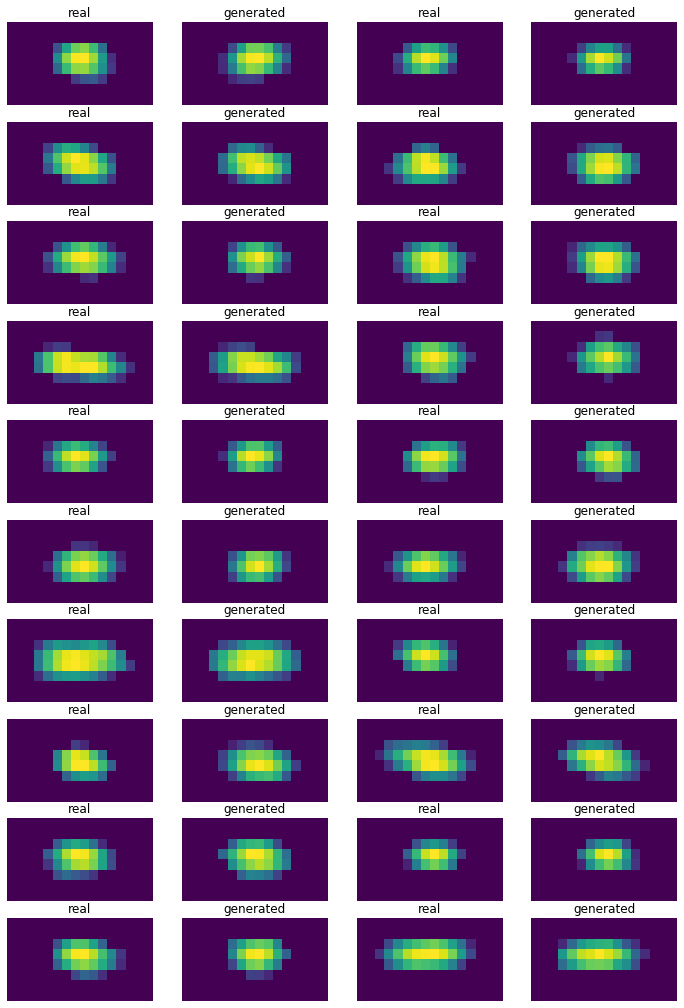

In [12]:
def plot_images(real, gen, n=10):
    assert real.shape == gen.shape
    assert real.ndim == 3
    assert n * 2 <= len(real)

    idx = np.sort(np.random.choice(len(real), n * 2, replace=False))
    real = real[idx]
    gen = gen[idx]

    size_x = 12
    size_y = size_x / real.shape[2] * real.shape[1] * n * 1.2 / 4

    fig, axx = plt.subplots(n, 4, figsize=(size_x, size_y))
    axx = [(ax[0], ax[1]) for ax in axx] + \
          [(ax[2], ax[3]) for ax in axx]

    for ax, img_real, img_fake in zip(axx, real, gen):
        ax[0].imshow(img_real, aspect='auto')
        ax[0].set_title("real")
        ax[0].axis('off')
        ax[1].imshow(img_fake, aspect='auto')
        ax[1].set_title('generated')
        ax[1].axis('off')

    return fig

plot_images(Y_train, Y_train_fake)

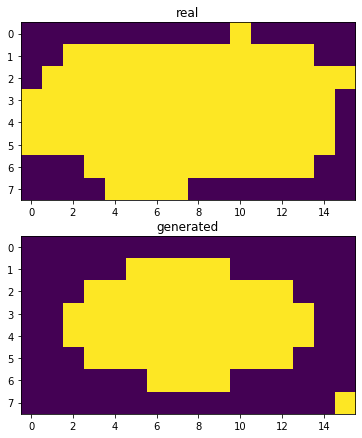

In [13]:
def plot_images_mask(real, gen):
    assert real.shape == gen.shape
    assert real.ndim == 3

    size_x = 6
    size_y = size_x / real.shape[2] * real.shape[1] * 2.4

    fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(size_x, size_y))
    ax0.imshow(real.any(axis=0), aspect='auto')
    ax0.set_title("real")
    ax1.imshow(gen.any(axis=0), aspect='auto')
    ax1.set_title("generated")

    return fig

fig = plot_images_mask(Y_train, Y_train_fake)